# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [99]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [100]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',delimiter=';')

In [101]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Dimensions of dataset:',azdias.shape)
azdias.head()

Dimensions of dataset: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [102]:
print('Dimensions of feat. info',feat_info.shape)
# Print out full info
with pd.option_context('display.max_rows',None):
    print(feat_info)

Dimensions of feat. info (85, 4)
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeri

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [103]:
# Identify missing or unknown data values and convert them to NaNs.

# Function for replacing missing values by NaNs
def replace_by_NaN(df,df_crit,lprint_missing=True):
    n_features = df.shape[1]
    if n_features != df_crit.shape[0]: raise ValueError("Incorrect dimensions "+str(n_features) 
                                                       + ' and ' + str(df_crit.shape[0]))
    
    for i in range(n_features):
        
        # Get criteria for missing values and convert them from string to list
        crit = df_crit.iloc[i,3]
        print(crit)
        crit = [x for x in crit[1:-1].split(',') if len(crit)>2]
    
        # Get a boolean mask, which tells us whether entries of a column fall within 'crit'
        mask = df.iloc[:,i].isin(crit)
        n_miss = mask.sum()
        col_name = df.columns[i]
        print("Nr. missing values for "+col_name,n_miss)
    
        # Replace missing values by NaNs
        df.loc[mask,col_name] = np.NaN   # DOn't use loc with integer indexing of columns!
        
    #return df
    

replace_by_NaN(azdias,feat_info)

[-1,0]
Nr. missing values for AGER_TYP 685843
[-1,0,9]
Nr. missing values for ALTERSKATEGORIE_GROB 2881
[-1,0]
Nr. missing values for ANREDE_KZ 0
[0]
Nr. missing values for CJT_GESAMTTYP 0
[-1]
Nr. missing values for FINANZ_MINIMALIST 0
[-1]
Nr. missing values for FINANZ_SPARER 0
[-1]
Nr. missing values for FINANZ_VORSORGER 0
[-1]
Nr. missing values for FINANZ_ANLEGER 0
[-1]
Nr. missing values for FINANZ_UNAUFFAELLIGER 0
[-1]
Nr. missing values for FINANZ_HAUSBAUER 0
[-1]
Nr. missing values for FINANZTYP 0
[0]
Nr. missing values for GEBURTSJAHR 392318
[]
Nr. missing values for GFK_URLAUBERTYP 0
[]
Nr. missing values for GREEN_AVANTGARDE 0
[-1,0]
Nr. missing values for HEALTH_TYP 111196
[0]
Nr. missing values for LP_LEBENSPHASE_FEIN 92778
[0]
Nr. missing values for LP_LEBENSPHASE_GROB 89718
[0]
Nr. missing values for LP_FAMILIE_FEIN 72938
[0]
Nr. missing values for LP_FAMILIE_GROB 72938
[0]
Nr. missing values for LP_STATUS_FEIN 0
[0]
Nr. missing values for LP_STATUS_GROB 0
[-1,0]
Nr. mi

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 [Text(0, 0, 'AGER_TYP'),
  Text(1, 0, 'GEBURTSJAHR'),
  Text(2, 0, 'HEALTH_TYP'),
  Text(3, 0, 'LP_LEBENSPHASE_FEIN'),
  Text(4, 0, 'LP_LEBENSPHASE_GROB'),
  Text(5, 0, 'LP_FAMILIE_FEIN'),
  Text(6, 0, 'LP_FAMILIE_GROB'),
  Text(7, 0, 'NATIONALITAET_KZ'),
  Text(8, 0, 'PRAEGENDE_JUGENDJAHRE'),
  Text(9, 0, 'SHOPPER_TYP'),
  Text(10, 0, 'SOHO_KZ'),
  Text(11, 0, 'TITEL_KZ'),
  Text(12, 0, 'VERS_TYP'),
  Text(13, 0, 'ALTER_HH'),
  Text(14, 0, 'ANZ_PERSONEN'),
  Text(15, 0, 'ANZ_TITEL'),
  Text(16, 0, 'HH_EINKOMMEN_SCORE'),
  Text(17, 0, 'KK_KUNDENTYP'),
  Text(18, 0, 'W_KEIT_KIND_HH'),
  Text(19, 0, 'WOHNDAUER_2008'),
  Text(20, 0, 'ANZ_HAUSHALTE_AKTIV'),
  Text(21, 0, 'ANZ_HH_TITEL'),
  Text(22, 0, 'GEBAEUDETYP'),
  Text(23, 0, 'KONSUMNAEHE

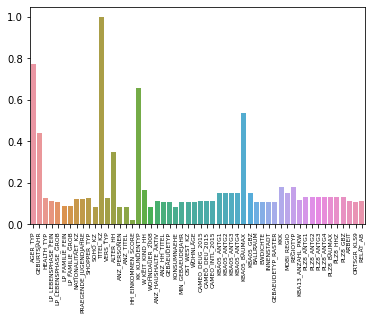

In [104]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Create mask for accessing certain columns above a certain percentage of NaNs
# Since we are only interested in columns, which actually have any outliers, set
# threshold to 1 %
cols = azdias.isna().sum()/azdias.shape[0] > 0.01
n_miss_proz = azdias.loc[:, azdias.columns[cols]].isna().sum()/azdias.shape[0]

# Make barplot of these values
sns.barplot(n_miss_proz.index,n_miss_proz.values) #,labels=azdias.columns)
plt.xticks(rotation=90,fontsize=6)


Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)


<AxesSubplot:ylabel='Count'>

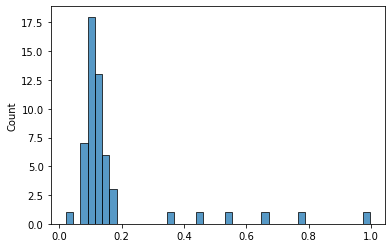

In [105]:
# Investigate patterns in the amount of missing data in each column.
!pip install seaborn -U

# Additionally, make a histogram, to get a more robust idea of outliers
sns.histplot(data=n_miss_proz)


In [106]:
# Quantify/Detect outliers using the interquantile range
def detect_outliers(data):
    # Compute upper bound (We do not care about values below the lower bound)
    iqr = data.quantile(0.75)-data.quantile(0.25)
    upper_bound = data.quantile(0.75) + 1.5*iqr
    
    # Print some statistics about the data set
    print("IQR:",iqr)
    print("Mean",data.mean())
    print("Median",data.median())
    print("Mode",data.mode())
    print("Upper outlier bound",upper_bound)
    
    # Get columns with values above upper bound (outliers)
    mask = data > upper_bound
    columns_rm = data.index[mask]
    return columns_rm

In [107]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Outliers seem to be above 20 % 
# Remove them from our dataset
columns_rm = detect_outliers(n_miss_proz)

print(columns_rm)
# Remove them and do not throw an error if the column has already been removed
print("Number of features before outlier removal: ",azdias.shape[1])
azdias.drop(columns_rm,inplace=True, axis=1, errors="ignore")
print("Number of features after outlier removal: ",azdias.shape[1])

IQR: 0.044415470461310946
Mean 0.1733353164636764
Median 0.12003981055204041
Mode 0    0.130736
dtype: float64
Upper outlier bound 0.2162202192273297
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
Number of features before outlier removal:  85
Number of features after outlier removal:  79


#### Discussion 1.1.2: Assess Missing Data in Each Column

From our analysis concerning outliers in the feature space (outlier features), we can make the following conclusions: <br>

<ul>
    <li> The distributions of missing values among the features is heavily right-skewed.</li>
    <li> Most of the features have around 13 % missing values.</li>
    <li> From the bar plot and the histogram above, we could actually already identify that
        outliers seem to have more than 20 % missing values.</li>
    <li> However, to be on the safe side, we implemented an outlier detection algorithm,
        which automatically detects outliers based on the interquantile range (IQR).</li>
    <li> This numerical and stastically more sound method, confirmed our observation that
        outliers can be identified as having more than 21.6 % missing values.</li>
    <li> Based on these arguments, it is fair to treat these outliers differently.
        We could only remove the most extreme ones of these outliers and replace the rest
        e.g. with the mode or median or average of the corresponding feature, but we
        decided that to just remove them from the dataset for an initial analysis.</li>
</ul>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Total rows (891221,)
Total rows with missing values (268012,)


<AxesSubplot:ylabel='Count'>

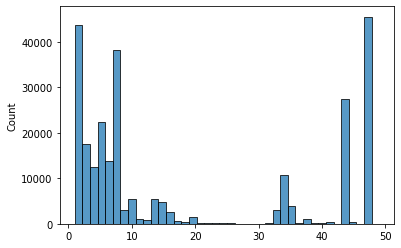

In [108]:
# How much data is missing in each row of the dataset?
acc = 0
n_miss_row = azdias.isna().sum(axis=1)
print('Total rows', n_miss_row.shape)
print('Total rows with missing values',n_miss_row[n_miss_row>0].shape)
#print('Individal rows with missing vaules\n',n_miss_row[n_miss_row>0])

sns.histplot(data=n_miss_row[n_miss_row>0])

In [109]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
n_few = 25
azdias_miss_row_few = azdias[n_miss_row<n_few].copy()
azdias_miss_row_lot = azdias[n_miss_row>=n_few]
print(azdias_miss_row_few.shape, azdias_miss_row_lot.shape)


(797906, 79) (93315, 79)


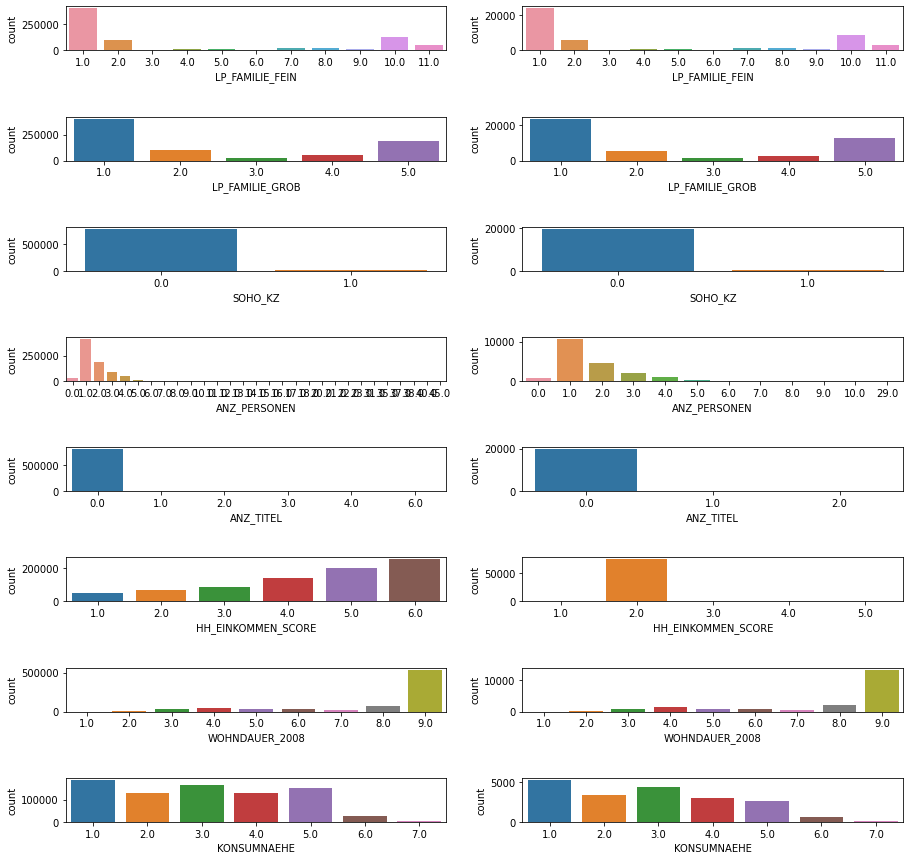

In [110]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Get columns with only few missing values
columns = n_miss_proz[n_miss_proz<0.1].index

fig, axs = plt.subplots(len(columns),2,figsize=(15,15))
plt.subplots_adjust(hspace=1.5)

for i in range(len(columns)):
    data_few = azdias_miss_row_few[columns[i]]
    data_lot = azdias_miss_row_lot[columns[i]]
    
    #print(data_few)
    
    sns.countplot(x=data_few, ax=axs[i,0])
    sns.countplot(x=data_lot, ax=axs[i,1])
    


In [111]:
# ANYWAYS: WE HAVE TO CONTINUE WITH NO MISSING VALUES SINCE THE ONE-HOT-ENCODING LATER
#          ON DOES NOT WORK
#azdias_miss_row_few = azdias[n_miss_row==0]
#print(azdias_miss_row_few.shape)

#### Discussion 1.1.3: Assess Missing Data in Each Row

All in all, the following observations can be made:

<ul>
    <li> The number of rows, which contain missing values, is about 1/3 of the entire dataset.</li>
    <li>The dataset can roughly be divided in two parts according to the above figure. One part which contains at most 25 missing values per row and another part which contains more than that since the distribution of missing values has two peaks.</li>
    <li> From the plots, which show the distribution of values for a subset of the columns with the fewest missing values, it can be concluded that for the majority of those columns the distributioins do look very similar between the data set, which only consists of rows with few missing values, and the dataset, which consists of rows with many missing values.</li>
    <li> There seems to be an exceptioin for the 'HH_EINKOMMEN_SCORE' column, where the distributions look quite different (monotonic increase vs. single peak). However,
        considering the fact that the remaining distributions almost look identical
        and that only about 11 % of our data fall in the "many missing values/row" category, it might be fair to start working only with the subset of data, which contains 
        a few missing values per row and potentially disregard the remaining subset after all.</li>
</ul>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [112]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [113]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Remove GEBAEUTYP from the dataset for reasons detailed in the discussion section below
azdias_miss_row_few.drop('GEBAEUDETYP', axis=1, inplace=True)

# Get list of categorical variables 
mask = feat_info['type']=='categorical'
col_tmp = list(feat_info[mask].attribute)

# Only take into account columns, which have not already been removed
col_categorical = []
for i in range(len(col_tmp)): 
    if col_tmp[i] in azdias_miss_row_few.columns: col_categorical.append(col_tmp[i])
        
# Print nr. of categories and their types
for i in range(len(col_categorical)):
    print(col_categorical[i], len(azdias_miss_row_few[col_categorical[i]].value_counts()),
         azdias_miss_row_few[col_categorical[i]].dtype)
    
# Print dataframe to see, which one is binary and needs re-encoding
azdias_miss_row_few[col_categorical].head()

ANREDE_KZ 2 float64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 float64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 object
CAMEO_DEU_2015 44 object


,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0.0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,W,8,8A
2,2.0,3.0,1.0,10.0,1.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,W,4,4C
3,2.0,2.0,6.0,1.0,0.0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,W,2,2A
4,1.0,5.0,5.0,5.0,0.0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,W,6,6B
5,2.0,2.0,2.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,W,8,8C


In [114]:
# Seems like 'OST_WEST_KZ' is the only binary categorical variable, which needs encoding
azdias_miss_row_few['OST_WEST_KZ'].value_counts()

W    629388
O    168518
Name: OST_WEST_KZ, dtype: int64

In [115]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_miss_row_few['OST_WEST_KZ'].replace({'W':0,'O':1},inplace=True)
azdias_miss_row_few['OST_WEST_KZ'].value_counts()

0    629388
1    168518
Name: OST_WEST_KZ, dtype: int64

In [116]:
# Drop CAMEO_2015_DEU from list since we will not want to use it anyways (see discussion)
# and it causes errors when imputing and one-hot-encoding
if 'CAMEO_DEU_2015' in col_categorical: 
    col_categorical.remove('CAMEO_DEU_2015')
    azdias_miss_row_few.drop(columns=['CAMEO_DEU_2015'], inplace=True, axis=1)

from sklearn.preprocessing import Imputer
    
    
print("Shape before imputation\n", azdias_miss_row_few.shape, azdias_miss_row_few[col_categorical].isna().sum())


# Use imputer to replace NaNs by their mode 
imputer_cat = Imputer(strategy="most_frequent", missing_values="NaN")
azdias_tmp = pd.DataFrame(imputer_cat.fit_transform(azdias_miss_row_few[col_categorical]), columns=col_categorical)

azdias_miss_row_few.reset_index(inplace=True, drop=True)

azdias_miss_row_few.loc[:,col_categorical] = azdias_tmp #.iloc[:,:]


print("Shape after imputation\n", azdias_miss_row_few.shape, azdias_miss_row_few[col_categorical].isna().sum())

Shape before imputation
 (797906, 77) ANREDE_KZ               0
CJT_GESAMTTYP        4678
FINANZTYP               0
GFK_URLAUBERTYP      4678
GREEN_AVANTGARDE        0
LP_FAMILIE_FEIN     31348
LP_FAMILIE_GROB     31348
LP_STATUS_FEIN       4678
LP_STATUS_GROB       4678
NATIONALITAET_KZ    33871
SHOPPER_TYP         36671
SOHO_KZ                 0
VERS_TYP            36671
ZABEOTYP                0
OST_WEST_KZ             0
CAMEO_DEUG_2015      6106
dtype: int64
Shape after imputation
 (797906, 77) ANREDE_KZ           0
CJT_GESAMTTYP       0
FINANZTYP           0
GFK_URLAUBERTYP     0
GREEN_AVANTGARDE    0
LP_FAMILIE_FEIN     0
LP_FAMILIE_GROB     0
LP_STATUS_FEIN      0
LP_STATUS_GROB      0
NATIONALITAET_KZ    0
SHOPPER_TYP         0
SOHO_KZ             0
VERS_TYP            0
ZABEOTYP            0
OST_WEST_KZ         0
CAMEO_DEUG_2015     0
dtype: int64


In [117]:
# One-Hot-Encode the multi-categorical data
from sklearn.preprocessing import OneHotEncoder


azdias_miss_row_few.reset_index(drop=True, inplace=True)

df_list = [azdias_miss_row_few]
for col in (col_categorical):
    if len(azdias_miss_row_few[col].value_counts()) > 2 and 'CAMEO_DEU_2015' not in col:
        encoder = OneHotEncoder(sparse=False)
    
        one_hot = encoder.fit_transform(azdias_miss_row_few[[col]])
        azdias_tmp = pd.DataFrame(one_hot, columns=[col + f'_{i}' 
                                                    for i in range(one_hot.shape[1])])

        df_list.append(azdias_tmp)

azdias_categorical = pd.concat(df_list, axis=1)
azdias_categorical.drop(columns=col_categorical,axis=1,inplace=True)

print(azdias_categorical.shape,azdias_miss_row_few.shape)
azdias_categorical.head()        

(797906, 138) (797906, 77)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,ZABEOTYP_5,CAMEO_DEUG_2015_0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

<ul>
    <li> The multi-categorical feature CAMEO_DEU_2015 has been removed from the feature
        space, since it contains redundant information compared to CAMEO_DEUG_2015 (Lifestage/Wealth). However, the CAMEO_DEU_2015 may be too fine-grained and contains a lot of useless information, which actually is not necessarily correlated with the wealth/income. What information do we gain from fancy categories like "Afternoon Talkshow" or "Sportgardener"? These are clichees, which do not tell us anything about the actual consumption or wealtch of a person. It makes more sense to keep a more coarse-grained mesh of categories, which are actually more meaningful, correlated with the aim of the category and actually interpretable (e.g. high/low consumtion, upper/middle class in CAMEO_DEUG_2015). </li>
    <li> All the remaining categorical variables have been kept, <b> except for GEBAEUDETYP since one-hot-encoding
        this leads to less features in the customer set than in the general population data set. This 
        indicates that the customer data set is not really representing parts of the general population.
        However, the information we delete here is already partially redundant with other information we
        have. Hence, there should not be a big loss of variability removing that column </b></li>
    <li> All binary variables, which are numerical, have been kept without modifications and the one of them,
    which was not numerical has been mapped to a binary feature.</li>
    <li>The remaining multi-categorical features are all numerical. However, they have been encoded via one-hot-encoding since otherwise the different increasing scores might affect the clustering by showing relationships,
        which do actually not exist in the data.</li>
</ul>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [118]:
# Get list of mixed variables 
mask = feat_info['type']=='mixed'
col_tmp = list(feat_info[mask].attribute)
col_tmp

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [119]:
col_mix = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


print("Shape before", azdias_categorical.shape, azdias_categorical[col_mix].isna().sum())


# Use imputer to replace NaNs by their mode 
imputer_mix = Imputer(strategy="most_frequent", missing_values="NaN")
azdias_tmp = pd.DataFrame(imputer_mix.fit_transform(azdias_categorical[col_mix]), columns=col_mix)

azdias_categorical.reset_index(inplace=True, drop=True)

azdias_categorical.loc[:,col_mix] = azdias_tmp #.iloc[:,:]


print("Shape after", azdias_categorical.shape, azdias_categorical[col_mix].isna().sum())

Shape before (797906, 138) PRAEGENDE_JUGENDJAHRE    28697
CAMEO_INTL_2015           6106
PLZ8_BAUMAX              23200
dtype: int64
Shape after (797906, 138) PRAEGENDE_JUGENDJAHRE    0
CAMEO_INTL_2015          0
PLZ8_BAUMAX              0
dtype: int64


In [120]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print('Original Series',azdias_categorical.shape)
print(azdias_categorical['PRAEGENDE_JUGENDJAHRE'].head(5))


# Define function, which turns decade into ordinal feature
def make_age(x):
    if int(x) in [1,2]: return 1
    if int(x) in [3,4]: return 2
    if int(x) in [5,6,7]: return 3
    if int(x) in [8,9]: return 4
    if int(x) in [10,11,12,13]: return 5
    if int(x) in [14,15]: return 6
    
# Define function, which turns categorical into binary
def make_cat(x):
    if int(x) in [1,3,5,8,10,12,14]: return 0
    return 1

# Engineer new features and save in series with new names
jugendjahre_age = azdias_categorical['PRAEGENDE_JUGENDJAHRE'].apply(make_age)
jugendjahre_cat = azdias_categorical['PRAEGENDE_JUGENDJAHRE'].apply(make_cat)
jugendjahre_age.name = "PRAEGENDE_JUGENDJAHRE_AGE"
jugendjahre_cat.name = "PRAEGENDE_JUGENDJAHRE_CAT"

# Append to original dataframe and remove obsolete mixed category
azdias_mixcat = pd.concat([ azdias_categorical, jugendjahre_age, jugendjahre_cat], axis=1)
azdias_mixcat.drop(columns=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

# Debug output for checking that everything worked as expected
print("After re-engineering", azdias_mixcat.shape)
azdias_mixcat[['PRAEGENDE_JUGENDJAHRE_AGE','PRAEGENDE_JUGENDJAHRE_CAT']].head()


Original Series (797906, 138)
0    14.0
1    15.0
2     8.0
3     8.0
4     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
After re-engineering (797906, 139)


,PRAEGENDE_JUGENDJAHRE_AGE,PRAEGENDE_JUGENDJAHRE_CAT
0,6,0
1,6,1
2,4,0
3,4,0
4,2,0


In [121]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

print('Original Series',azdias_mixcat.shape)
print(azdias_mixcat['CAMEO_INTL_2015'].head(5))


# Define function, which returns first decimal place
def make_cat1(x):
    return int(x)%10
    
# Define function, which returns second decimal place
def make_cat2(x):
    return int(x)//10

# Engineer new features and save in series with new names
cameo_1 = azdias_mixcat['CAMEO_INTL_2015'].apply(make_cat1)
cameo_2 = azdias_mixcat['CAMEO_INTL_2015'].apply(make_cat2)
cameo_1.name = "CAMEO_INTL_2015_1"
cameo_2.name = "CAMEO_INTL_2015_2"

# Append to original dataframe and remove obsolete mixed category
azdias_mixcat = pd.concat([ azdias_mixcat, cameo_1, cameo_2], axis=1)
azdias_mixcat.drop(columns=['CAMEO_INTL_2015'], axis=1, inplace=True)

# Debug output for checking that everything worked as expected
print("After re-engineering", azdias_mixcat.shape)
azdias_mixcat[['CAMEO_INTL_2015_1','CAMEO_INTL_2015_2']].head()


Original Series (797906, 139)
0    51.0
1    24.0
2    12.0
3    43.0
4    54.0
Name: CAMEO_INTL_2015, dtype: float64
After re-engineering (797906, 140)


,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
0,1,5
1,4,2
2,2,1
3,3,4
4,4,5


In [122]:
# Re-engineer PLZ8_BAUMAX
print('Original Series',azdias_mixcat.shape)
print(azdias_mixcat['PLZ8_BAUMAX'].head(5))

azdias_mixcat['PLZ8_BAUMAX'] = azdias_mixcat['PLZ8_BAUMAX'].apply(lambda x: 1 if x==5 else 0)

print('After re-engineering',azdias_mixcat.shape)
print(azdias_mixcat['PLZ8_BAUMAX'].head(15))

Original Series (797906, 140)
0    1.0
1    1.0
2    1.0
3    2.0
4    1.0
Name: PLZ8_BAUMAX, dtype: float64
After re-engineering (797906, 140)
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
Name: PLZ8_BAUMAX, dtype: int64


In [123]:
# Drop useless mixed features
columns_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE']
azdias_mixcat.drop(columns=columns_drop, axis=1, inplace=True)

azdias_mixcat.shape

(797906, 137)

#### Discussion 1.2.2: Engineer Mixed-Type Features

<ul>
    <li> LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB since I simply did not understand why and how there is a
        differentiation between 'earning' and 'income'. Additionally, none of the features presented there 
        (martial status, income, earning, age) was consistently present throughout all the possible entries, 
        which makes it difficult to encode. Furthermore, the main information (earning/income) is already present
        some of our other features, which makes that part at least partially redundant and, hence, ignorable.</li>
    <li> WOHNLAGE has been dropped for similar reasons as LP_LEBENSLAGE*. No consitent information throughout the
        values and some values such as "new building in rural neighborhood" are not assignable.
        Obviously, one could just drop the corresponding rows and use an ordinal variable to encode the remaining 
        values but this would not make much sense here, since this feature again is highly correlated with 
        income/wealth and deleting valuable data in our dataset for keeping a redundant feature does not make much
        sense to me.</li>
    <li> Dropped KBA05_BAUMAX already previously due to high number of missing values.</li>
    <li> PLZ8_BAUMAX could be re-engineered to a binary variable. Since PLZ8_ANTG1-4 contain information about the 
        predominant family homes in the area, we can use PLZ8_BAUMAX to tell us whether there are mostly
        businesses (1) or not (0). All the other information contained in PLZ8_BAUMAX would be redundant to the
        information in PLZ8_ANTG1-4.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [124]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [125]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



<b> Everything should be fine. I included a check and debug output after each step such as e.g. printing a few columns and checking that the number of rows and columns after each step are what they should be</b>

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [126]:
# Function for replacing missing values by NaNs
def replace_by_NaN(df,df_crit):
    n_features = df.shape[1]
    if n_features != df_crit.shape[0]: raise ValueError("Incorrect dimensions "+str(n_features) 
                                                       + ' and ' + str(df_crit.shape[0]))
    
    for i in range(n_features):
        
        # Get criteria for missing values and convert them from string to list
        crit = df_crit.iloc[i,3]
        print(crit)
        crit = [x for x in crit[1:-1].split(',') if len(crit)>2]
    
        # Get a boolean mask, which tells us whether entries of a column fall within 'crit'
        mask = df.iloc[:,i].isin(crit)
        n_miss = mask.sum()
        col_name = df.columns[i]
        print("Nr. missing values for "+col_name,n_miss)
    
        # Replace missing values by NaNs
        df.loc[mask,col_name] = np.NaN
        
    return df

In [127]:
# Filter columns
def filter_columns(df, columns_rm):

    # We should use the exact same features for both datasets.
    # Hence, outlier detection is not really necessary here. 
    return df.drop(columns_rm, axis=1)

In [128]:
# Check and filter rows
def filter_rows(df, n_keep):

    # How much data is missing in each row of the dataset?
    n_miss_row = df.isna().sum(axis=1)
    print('Total rows', n_miss_row.shape)
    print('Total rows with missing values',n_miss_row[n_miss_row>0].shape)
        
    # Write code to divide the data into two subsets based on the number of missing
    # values we wanna accept in each row.
    azdias_miss_row_few = df[n_miss_row<n_keep]
    azdias_miss_row_lot = df[n_miss_row>=n_keep]
    print("Dim. row keep", azdias_miss_row_few.shape)
    print("Dim. row lot", azdias_miss_row_lot.shape)
    
    return df[n_miss_row<n_keep]

In [129]:
def engineer_multi_cat(df, df_info):
    
    # Get list of categorical variables 
    mask = feat_info['type']=='categorical'
    col_tmp = list(feat_info[mask].attribute)

    # Only take into account columns, which have not already been removed
    col_categorical = []
    for i in range(len(col_tmp)): 
        if col_tmp[i] in df.columns: col_categorical.append(col_tmp[i])
    
    
    ###### MULTI FEATURES ######
    
    # One-Hot-Encode multi-categorical variables
    df.reset_index(drop=True, inplace=True)
    df_list = [df]
    
    for col in (col_categorical):
        if len(df[col].value_counts()) > 2 and 'CAMEO_DEU_2015' not in col:
            encoder = OneHotEncoder(sparse=False)
            one_hot = encoder.fit_transform(df[[col]])
            df_tmp = pd.DataFrame(one_hot, columns=[col + f'_{i}' 
                                                    for i in range(one_hot.shape[1])])
            df_list.append(df_tmp)
            print('col: ', df_tmp.columns)
            
    df_categorical = pd.concat(df_list, axis=1)
    
    return df_categorical.drop(columns=col_categorical,axis=1)

In [130]:
def engineer_mixed(df):
    # Define helper functions to apply to df
    def make_age(x):
        if int(x) in [1,2]: return 1
        if int(x) in [3,4]: return 2
        if int(x) in [5,6,7]: return 3
        if int(x) in [8,9]: return 4
        if int(x) in [10,11,12,13]: return 5
        if int(x) in [14,15]: return 6
    
    def make_cat(x):
        if int(x) in [1,3,5,8,10,12,14]: return 0
        return 1
    
    def make_cat1(x):
        return int(x)%10
    
    def make_cat2(x):
        return int(x)//10

    ###### FEATURE 1 #######
    
    # Engineer new features and save in series with new names
    jugendjahre_age = df['PRAEGENDE_JUGENDJAHRE'].apply(make_age)
    jugendjahre_cat = df['PRAEGENDE_JUGENDJAHRE'].apply(make_cat)
    jugendjahre_age.name = "PRAEGENDE_JUGENDJAHRE_AGE"
    jugendjahre_cat.name = "PRAEGENDE_JUGENDJAHRE_CAT"

    # Append to original dataframe and remove obsolete mixed category
    df_cat1 = pd.concat([ df, jugendjahre_age, jugendjahre_cat], axis=1)
    df_cat1.drop(columns=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)


    
    ###### FEATURE 2 ######

    # Engineer new features and save in series with new names
    cameo_1 = df_cat1['CAMEO_INTL_2015'].apply(make_cat1)
    cameo_2 = df_cat1['CAMEO_INTL_2015'].apply(make_cat2)
    cameo_1.name = "CAMEO_INTL_2015_1"
    cameo_2.name = "CAMEO_INTL_2015_2"

    # Append to original dataframe and remove obsolete mixed category
    df_cat2 = pd.concat([ df_cat1, cameo_1, cameo_2], axis=1)
    df_cat2.drop(columns=['CAMEO_INTL_2015'], axis=1, inplace=True)


    
    ###### FEATURE 3 ######
    df_cat2['PLZ8_BAUMAX'] = df_cat2['PLZ8_BAUMAX'].apply(lambda x: 1 if x==5 else 0)
   

    # Remove useless mixed features
    columns_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE']
    df_cat2.drop(columns=columns_drop, axis=1, inplace=True)
    
    return df_cat2

In [131]:
def impute_df(df, df_info, ctype, cols=None, imputer=None):
    
    lfit = imputer==None
    strategy = 'most_frequent' if ctype!='numeric' else 'mean'
    
    if cols==None:
        # Get list of ctype features 
        mask = feat_info['type']==ctype
        col_tmp = list(feat_info[mask].attribute)
        # Only take into account columns, which have not already been removed
        columns = []
        for i in range(len(col_tmp)): 
            if col_tmp[i] in df.columns: columns.append(col_tmp[i])
    else:
        columns = cols

    
    print("Shape before imputation\n", df.shape, df[columns].isna().sum().sum())

    # Use imputer to replace NaNs by their mode 
    if lfit:
        imputer = Imputer(strategy=strategy, missing_values="NaN")
        df_tmp = pd.DataFrame(imputer.fit_transform(df[columns]), columns=columns)
    else:
        df_tmp = pd.DataFrame(imputer.transform(df[columns]), columns=columns)
        
    df.reset_index(inplace=True, drop=True)

    df.loc[:,columns] = df_tmp #.iloc[:,:]

    print("Shape after imputation\n", df.shape, df[columns].isna().sum().sum())
    
    
    return df

In [132]:
def clean_data(df, df_info, columns_rm, columns_mix, nkeep, imputer_cat=None, imputer_mix=None,
              imputer_ordinal=None, imputer_numeric=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    df_clean = replace_by_NaN(df, df_info)
    
    # remove selected columns and rows, ...
    df_clean = filter_columns(df_clean, columns_rm)
    df_clean = filter_rows(df_clean, nkeep)
    
    
    # Engineer binary variable (no automatic detection here: Just do the same for both data sets)
    df_clean['OST_WEST_KZ'].replace({'W':0,'O':1}, inplace=True)

    # Remove CAMEO_DEU_2015
    df_clean.drop(columns=['CAMEO_DEU_2015'], inplace=True, axis=1)
    
    # Remove GEBAEUDETYP since one-hot-encoding this yields inconsitent number of columns betweeen
    # customer and general population data
    df_clean.drop('GEBAEUDETYP', axis=1, inplace=True)
    
    # Impute, select, re-encode, and engineer multi-categorical features
    lfit = imputer_cat==None
    df_clean = impute_df(df_clean, df_info, 'categorical', imputer=imputer_cat)
    df_clean = engineer_multi_cat(df_clean, df_info)
    
    # Impute, select, re-encode, and engineer mixed features
    lfit = imputer_mix==None
    df_clean = impute_df(df_clean, df_info, 'mixed', cols=columns_mix, imputer=imputer_mix)
    df_clean = engineer_mixed(df_clean)
    
    # Impute remaining features (ordinal and numeric)
    lfit = imputer_ordinal==None
    df_clean = impute_df(df_clean, df_info, 'ordinal', imputer=imputer_ordinal)
    lfit = imputer_numeric==None
    df_clean = impute_df(df_clean, df_info, 'numeric', imputer=imputer_numeric)
    
    # Return the cleaned dataframe.
    return df_clean

In [133]:
# Check if we get consistent results
#tmp = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
#tmp_clean = clean_data(tmp, feat_info, columns_rm, col_mix, n_few)

In [134]:
# Check if we get consistent results
#tmp = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
#tmp_clean = clean_data(tmp, feat_info, columns_rm, col_mix, n_few)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [135]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

###### IMPUTE ORDINAL VALUES ######

print(feat_info['type'].value_counts())

# Get ordinal type data to apply imputation using 'mode'
mask = feat_info['type'] == 'ordinal'
col_tmp = list(feat_info[mask].attribute)

# Make sure to include only columns which are still present in original dataframe
col_ordinal = []
for col in col_tmp:
    if col in azdias_mixcat.columns: col_ordinal.append(col)
        
        
print('Shape and NaNs before imputation\n', azdias_mixcat.shape,
      azdias_mixcat[col_ordinal].isna().sum().sum())

# Apply imputer using the most frequent ('mode') entries
imputer_ordinal = Imputer(missing_values='NaN', strategy='most_frequent')
azdias_tmp = pd.DataFrame(imputer_ordinal.fit_transform(azdias_mixcat[col_ordinal]), columns=col_ordinal)

# Reset and drop indices to make sure the replacement works as expected
azdias_mixcat.reset_index(inplace=True, drop=True)

# Replace original columns with imputed ones
azdias_mixcat[col_ordinal] = azdias_tmp

print('Shape and NaNs after imputation\n', azdias_mixcat.shape,
      azdias_mixcat[col_ordinal].isna().sum().sum())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64
Shape and NaNs before imputation
 (797906, 137) 631263
Shape and NaNs after imputation
 (797906, 137) 0


In [136]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

###### IMPUTE NUMERIC VALUES ######

# Get ordinal type data to apply imputation using 'mean'
mask = feat_info['type'] == 'numeric'
col_tmp = list(feat_info[mask].attribute)

# Make sure to include only columns which are still present in original dataframe
col_numeric = []
for col in col_tmp:
    if col in azdias_mixcat.columns: col_numeric.append(col)
        
        
print('Shape and NaNs before imputation\n', azdias_mixcat.shape,
      azdias_mixcat[col_numeric].isna().sum().sum())

# Apply imputer using the most frequent ('mode') entries
imputer_numeric = Imputer(missing_values='NaN', strategy='mean')
azdias_tmp = pd.DataFrame(imputer_numeric.fit_transform(azdias_mixcat[col_numeric]), columns=col_numeric)

# Reset and drop indices to make sure the replacement works as expected
azdias_mixcat.reset_index(inplace=True, drop=True)

# Replace original columns with imputed ones
azdias_mixcat[col_numeric] = azdias_tmp

print('Shape and NaNs after imputation\n', azdias_mixcat.shape,
      azdias_mixcat[col_numeric].isna().sum().sum())

Shape and NaNs before imputation
 (797906, 137) 22770
Shape and NaNs after imputation
 (797906, 137) 0


In [137]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_ready = pd.DataFrame(scaler.fit_transform(azdias_mixcat), columns=azdias_mixcat.columns)

print("Shape after scaling", azdias_ready.shape)
azdias_ready.head(10)

Shape after scaling (797906, 137)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,PRAEGENDE_JUGENDJAHRE_AGE,PRAEGENDE_JUGENDJAHRE_CAT,CAMEO_INTL_2015_1,CAMEO_INTL_2015_2
0,-1.766583,-1.494563,1.537958,-1.040677,1.466028,0.958855,1.339191,1.010173,-1.685322,0.443085,...,-0.386920,-0.272885,-0.391135,-0.329005,2.162709,-0.396028,1.098148,-0.530442,-1.249066,1.175762
1,0.200534,-1.494563,0.864598,-1.766947,-0.570971,0.244297,1.339191,1.010173,-0.310776,-0.072128,...,2.584513,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,1.098148,1.885219,0.766959,-0.869616
2,1.184092,0.683201,-0.482123,1.138132,-0.570971,-1.184817,-0.791446,-0.311822,-0.998049,0.443085,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,-0.267680,-0.530442,-0.577058,-1.551409
3,0.200534,0.683201,0.191237,0.411863,-1.249970,0.244297,-0.791446,1.010173,1.063770,0.958297,...,-0.386920,-0.272885,2.556661,-0.329005,-0.462383,-0.396028,-0.267680,-0.530442,0.094950,0.493969
4,-1.766583,-0.042721,-1.155483,1.138132,-0.570971,-0.470260,1.339191,1.010173,-0.310776,-1.102553,...,-0.386920,-0.272885,-0.391135,-0.329005,2.162709,-0.396028,-1.633507,-0.530442,0.766959,1.175762
5,-0.783024,-1.494563,1.537958,-1.766947,1.466028,0.958855,-0.081234,-0.311822,0.376497,-1.102553,...,2.584513,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,0.415234,-0.530442,-0.577058,-0.869616
6,-1.766583,-0.042721,0.191237,0.411863,-1.249970,0.244297,-0.791446,-1.633817,1.063770,1.473510,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,-0.267680,-0.530442,0.766959,-1.551409
7,0.200534,0.683201,0.864598,-1.040677,0.787029,-0.470260,-0.791446,1.010173,0.376497,-0.072128,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,0.415234,1.885219,0.094950,-1.551409
8,0.200534,-0.768642,0.864598,-1.040677,0.108029,1.673412,0.628979,-0.311822,0.376497,-1.102553,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.462383,-0.396028,1.098148,1.885219,1.438967,-1.551409
9,0.200534,-0.768642,-0.482123,1.138132,0.108029,-1.184817,1.339191,-0.311822,1.063770,0.443085,...,-0.386920,-0.272885,-0.391135,-0.329005,-0.462383,2.525074,-1.633507,-0.530442,-1.249066,1.175762


### Discussion 2.1: Apply Feature Scaling

<b> Imputation: </b>
<ul>
    <li> ALTER_HH has already been detected as an outlier and has been removed. =>
        No interval type data left  for imputation</li>
    <li> Imputation of mixed and categorical features has already been performed prior to engineering these features
        (see previous sections). For the imputation the <b> categorical, mixed and ordinal </b> features
        the most frequent results ('mode') have been used.
        Alternatively, using the median would also be a viable option for these features. However, the frequency
        makes equally as much sense from my point of view. To arrive at a more rigorous conclusion about which
        type of imputation makes more sense, some hypothesis testing would have to be performed or one could
        just see, which one of these leads to less bias.</li>
    <li> For imputation of the numerical features, the mean has been used. Here, the median or another imputation
        method would have also made sense. Again, finding the best imputation method here would need some more 
        testing but using the mean for numerical values is quite common.</li>
    <li> Furthermore, the amount of samples with missing values is roughly 11 %. Hence, any kind of 
        reasonable imputation should not result in too much bias.</li>
</ul>


<br><b> Scaling </b>
<ul>
    <li> The Standard scaler has been used to scale all features to zero mean and unit variance. Actually, a min-max scaler might have also made sense if we used a different clustering technique. But since k-means clusters data
        in hyperspheres, having a uniform distribution might be beneficial for k-means to work. </li>
</ul>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [138]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_ready)

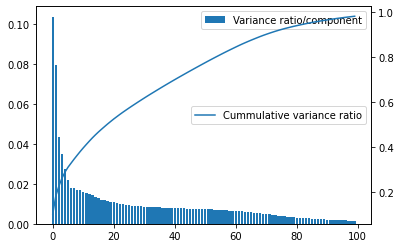

In [139]:
# Investigate the variance accounted for by each principal component.
%matplotlib inline
fig, ax = plt.subplots()
ncmp = 100

# Plot individual explained variance ratio
xticks = range(len(pca.explained_variance_[:ncmp]))
ax.bar(xticks,pca.explained_variance_ratio_[:ncmp],label="Variance ratio/component") #, ax=ax)
plt.legend(loc="upper right")

# Plot cumulative explained variance ratio
ax_line = ax.twinx()
ax_line.plot(xticks,np.cumsum(pca.explained_variance_ratio_[:ncmp]),label="Cummulative variance ratio")
plt.legend(loc="center right")

In [140]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
azdias_pca = pca.fit_transform(azdias_ready)


### Discussion 2.2: Perform Dimensionality Reduction

30 principal components (PCs) should be a proper number. This is because the variance explained by the components 30 - 65 is about the same for each and every component in that range, i.e. all of these PCs are equally important and, hence, justifying any cutoff above 30 components is only arbitrary. But before the 30th PC, the variance explained drops rather quickly, meaning that these components are most important to explain the variance in the data. Furthermore, the cumulative variance explained by the first 30 PCs is already 60 %, which seems like a good comporomise between accuracy and computational savings (I also tried a PCA using more than 40 components and this was already incredibly expensive).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [141]:
def map_components(feature_names, comp):
    #columns = df.columns
    #comp = pca.components_[icomp,:]
    
    mapping = pd.Series(comp,index=feature_names)
    return mapping.sort_values(ascending=False)

In [142]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#map1 = map_components(pca, azdias_ready, 0)
feature_names = azdias_ready.columns
components = pca.components_
map1 = map_components(feature_names, components[0,:])


print("Largest components for PC 1\n",map1.head())
print("\n Smallest components for PC 1\n",map1.tail())

Largest components for PC 1
 LP_STATUS_GROB_0      0.200618
PLZ8_ANTG3            0.185530
HH_EINKOMMEN_SCORE    0.184656
CAMEO_INTL_2015_2     0.180685
PLZ8_ANTG4            0.179028
dtype: float64

 Smallest components for PC 1
 KBA05_ANTG1         -0.182715
KBA05_GBZ           -0.183622
PLZ8_ANTG1          -0.185844
MOBI_REGIO          -0.190976
FINANZ_MINIMALIST   -0.203807
dtype: float64


In [143]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#map2 = map_components(pca, azdias_ready, 1)
map2 = map_components(feature_names, components[1,:])

print("Largest components for PC 2\n",map2.head())
print("\n Smallest components for PC 2\n",map2.tail())

Largest components for PC 2
 ALTERSKATEGORIE_GROB    0.227129
FINANZ_VORSORGER        0.213679
ZABEOTYP_2              0.199600
SEMIO_ERL               0.173896
SEMIO_LUST              0.159540
dtype: float64

 Smallest components for PC 2
 SEMIO_TRADV                 -0.204009
SEMIO_REL                   -0.206835
FINANZ_UNAUFFAELLIGER       -0.211429
FINANZ_SPARER               -0.218270
PRAEGENDE_JUGENDJAHRE_AGE   -0.225329
dtype: float64


In [144]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.


#map3 = map_components(pca, azdias_ready, 2)
map3 = map_components(feature_names, components[2,:])

print("Largest components for PC 3\n",map3.head(7))
print("\n Smallest components for PC 3\n",map3.tail(7))

Largest components for PC 3
 SEMIO_VERT           0.336673
SEMIO_FAM            0.280322
SEMIO_SOZ            0.275958
SEMIO_KULT           0.270284
FINANZTYP_4          0.145854
FINANZ_MINIMALIST    0.139627
SHOPPER_TYP_0        0.138061
dtype: float64

 Smallest components for PC 3
 FINANZTYP_0      -0.107486
SEMIO_RAT        -0.154665
FINANZ_ANLEGER   -0.162504
SEMIO_ERL        -0.227008
SEMIO_KRIT       -0.289035
SEMIO_DOM        -0.302644
SEMIO_KAEM       -0.332699
dtype: float64


### Discussion 2.3: Interpret Principal Components

<b> PC 1</b>
<ul>
    <li>The first principal component seems to be positively correlated with features which are associated living conditions and wealth. The positive correlation to CAMEO_INTL_2015, LP_STATUS_GROB_0 (lowest category one-hot-encoded) and HH_EINKOMMEN_SCORE means that there is a positive correlation between PC1 and the poorness of a person (In these features, the higher the score, the lower the income). Consequently, this is also reflected in the living conditions given by PLZ8_ANTG3-4. Here, there is a positive correlation between the number of multi-family housings (6 - 10+) and PC1. This is consistent with the wealth of a person since wealthy people tend to not live in places, like PLZ_ANTG1 and KBA05_ANTG1 (negative correlation seen here also makes perfect sense).</li>
    <li> Additional interesting negative correlations  are with MOBI_REGIO (mobility pattern). This also makes intuitive sense taking into account the positive correlation with poorness. Poorer people tend to be less mobile due to the lack of money for a car or public transportation (low scores indicate low movement here)</li>
</ul>

<b> PC 2 </b>
<ul>
    <li> The secon PC seems to be less about wealtch but summarizes more of the mindset and personality traits of people. Positive correlation with younger age, event oriented and smart when it comes to energy savings.</li>
    <li> Consequently, there is a negative correlation to older people and - which makes perfect sense - traditional-minded and religious values.</li>
    <li> Another interesting thing is that there seems to be a positive correlation to people, who wanna be financially prepared (in the process of getting savings => young) and people who can already be categorized as money-savers (=> older).</li>
</ul>

<b>PC 3</b> 

<ul>
    <li>While the second PC seemed more concerned with the rough and more surface-level categorization of people, PC 3 seems to care more about people's actual personality: Postivie correlation with being dreamful, social and cultural-minded.</li>
    <li> And there is a negative correlation with quite obviously opposite personalities, i.e. being combative, dominant, critical</li>


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [145]:
from sklearn.cluster import KMeans

scores = []
max_clusters = 21
for i in range(2,max_clusters):
    print("Perform K-Means for " + str(i) + " clusters")
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(azdias_pca)
    scores.append(model.score(azdias_pca))

Perform K-Means for 2 clusters
Perform K-Means for 3 clusters
Perform K-Means for 4 clusters
Perform K-Means for 5 clusters
Perform K-Means for 6 clusters
Perform K-Means for 7 clusters
Perform K-Means for 8 clusters
Perform K-Means for 9 clusters
Perform K-Means for 10 clusters
Perform K-Means for 11 clusters
Perform K-Means for 12 clusters
Perform K-Means for 13 clusters
Perform K-Means for 14 clusters
Perform K-Means for 15 clusters
Perform K-Means for 16 clusters
Perform K-Means for 17 clusters
Perform K-Means for 18 clusters
Perform K-Means for 19 clusters
Perform K-Means for 20 clusters


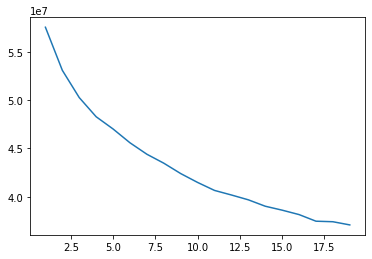

In [146]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(range(1,len(scores)+1),-np.array(scores))

In [152]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters)
model = kmeans.fit(azdias_pca)

labels_azdias = kmeans.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

Using 15 clusters seems like a good compromise between bias and variance. Using significantly more clusters might result in too many clusters, which are difficult to interpret. Furthermore, this point seems like being close to the elbow, i.e.  after 15 cluster, the distance only decreases sublinearly with additional clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [153]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [154]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Note to myself:
# Impute categorical data using the same imputer as for the general population.
# => Imputer applies mode/mean from general population to customer data
#    since the fit() method would again refit the imputer to the customer data.
# (fit() leads to change/adaption of internal state to new data of any sklearn object)
# => Hand over imputer to clean_data function 

# Clean, select and impute features
customers_clean = clean_data(customers, feat_info, columns_rm, col_mix, n_few, imputer_cat=imputer_cat, 
                             imputer_mix=imputer_mix, imputer_ordinal=imputer_ordinal, 
                             imputer_numeric=imputer_numeric)

[-1,0]
Nr. missing values for AGER_TYP 96738
[-1,0,9]
Nr. missing values for ALTERSKATEGORIE_GROB 240
[-1,0]
Nr. missing values for ANREDE_KZ 0
[0]
Nr. missing values for CJT_GESAMTTYP 0
[-1]
Nr. missing values for FINANZ_MINIMALIST 0
[-1]
Nr. missing values for FINANZ_SPARER 0
[-1]
Nr. missing values for FINANZ_VORSORGER 0
[-1]
Nr. missing values for FINANZ_ANLEGER 0
[-1]
Nr. missing values for FINANZ_UNAUFFAELLIGER 0
[-1]
Nr. missing values for FINANZ_HAUSBAUER 0
[-1]
Nr. missing values for FINANZTYP 0
[0]
Nr. missing values for GEBURTSJAHR 93024
[]
Nr. missing values for GFK_URLAUBERTYP 0
[]
Nr. missing values for GREEN_AVANTGARDE 0
[-1,0]
Nr. missing values for HEALTH_TYP 48990
[0]
Nr. missing values for LP_LEBENSPHASE_FEIN 47840
[0]
Nr. missing values for LP_LEBENSPHASE_GROB 47728
[0]
Nr. missing values for LP_FAMILIE_FEIN 47369
[0]
Nr. missing values for LP_FAMILIE_GROB 47369
[0]
Nr. missing values for LP_STATUS_FEIN 0
[0]
Nr. missing values for LP_STATUS_GROB 0
[-1,0]
Nr. missin

In [155]:
# Apply standard scaler
customers_scaled = scaler.transform(customers_clean)

In [156]:
# Perform PCA
customers_pca = pca.transform(customers_scaled)

In [157]:
# Predict cluster centers for customer data
labels_customers = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

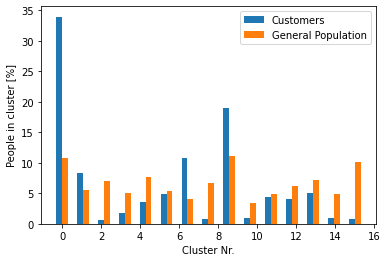

In [168]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compute proportions and save to list
prop_customers = []
prop_azdias = []
for i in range(n_clusters):
    prop_customers.append(len(labels_customers[labels_customers==i])/len(labels_customers)*100)
    prop_azdias.append(len(labels_azdias[labels_azdias==i])/len(labels_azdias)*100)

# Make bar plot
bar_width = 0.3
x_range1 = np.linspace(0, n_clusters, n_clusters) - bar_width/2
x_range2 = np.linspace(0, n_clusters, n_clusters) + bar_width/2
plt.bar(x_range1, prop_customers, width=bar_width, label="Customers")
plt.bar(x_range2, prop_azdias, width=bar_width, label="General Population")
plt.xlabel("Cluster Nr.")
plt.ylabel("People in cluster [%]")
plt.legend()

In [169]:
# Helper function to compute the PC scores
def cluster_info(data, labels, icluster):
    # Extract subset corresponding to cluster i
    cluster_subset = data[labels==icluster]
    
    # Compute mean along each feature in the reduced space
    cluster_mean = cluster_subset.mean(axis=0)
    
    # Project this mean to original space to get scores
    pc_scores = cluster_mean.dot(pca.components_)
    
    # Use function defined earlier to map PC loadings to features
    map1 = map_components(feature_names, pc_scores)
    
    # Print results
    print("Largest positive correlations for cluster"+str(icluster)+"\n",map1.head(5))
    print("\n Largest negative correlations for cluster"+str(icluster)+"\n",map1.tail(5))

In [170]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#### Clusters 0, 6 and 8 are significantly overrepresented in customer data ###

## CLUSTER 0 ##
cluster_info(customers_pca, labels_customers, 0)

Largest positive correlations for cluster0
 LP_STATUS_FEIN_9             2.339901
LP_STATUS_GROB_4             2.339901
PRAEGENDE_JUGENDJAHRE_CAT    1.889615
FINANZ_MINIMALIST            1.301148
KBA05_ANTG1                  1.037835
dtype: float64

 Largest negative correlations for cluster0
 CAMEO_INTL_2015_2           -0.851634
PRAEGENDE_JUGENDJAHRE_AGE   -0.896186
FINANZ_SPARER               -1.015451
FINANZ_ANLEGER              -1.111398
HH_EINKOMMEN_SCORE          -1.392880
dtype: float64


In [171]:
## CLUSTER 6 ##
cluster_info(customers_pca, labels_customers, 6)

Largest positive correlations for cluster6
 LP_STATUS_GROB_2    4.251894
LP_STATUS_FEIN_6    4.140416
ANZ_TITEL           3.599861
LP_STATUS_FEIN_5    2.486555
ANZ_HH_TITEL        1.482324
dtype: float64

 Largest negative correlations for cluster6
 PRAEGENDE_JUGENDJAHRE_AGE   -0.815998
FINANZ_ANLEGER              -0.834952
FINANZ_SPARER               -0.876116
LP_STATUS_GROB_0            -0.910826
HH_EINKOMMEN_SCORE          -1.037948
dtype: float64


In [172]:
## CLUSTER 8 ##
cluster_info(customers_pca, labels_customers, 8)

Largest positive correlations for cluster8
 LP_STATUS_FEIN_8     1.979612
LP_STATUS_GROB_3     1.910673
FINANZ_MINIMALIST    1.282576
MOBI_REGIO           0.928716
FINANZ_VORSORGER     0.928465
dtype: float64

 Largest negative correlations for cluster8
 PLZ8_ANTG3                  -0.815686
EWDICHTE                    -0.854520
ORTSGR_KLS9                 -0.893166
PRAEGENDE_JUGENDJAHRE_AGE   -0.894726
FINANZ_SPARER               -1.002203
dtype: float64


In [176]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#### Clusters 2, 7 and 14 are significantly overrepresented in general population data ###

## CLUSTER 2 ##
cluster_info(customers_pca, labels_customers, 2)

Largest positive correlations for cluster2
 SEMIO_FAM     1.304719
SEMIO_KULT    1.256340
SEMIO_SOZ     1.212237
SEMIO_REL     1.000646
PLZ8_ANTG4    0.985129
dtype: float64

 Largest negative correlations for cluster2
 SEMIO_KAEM         -0.941718
SEMIO_KRIT         -0.944849
PLZ8_ANTG1         -0.952524
FINANZ_VORSORGER   -0.983145
SEMIO_ERL          -1.169375
dtype: float64


In [174]:
## CLUSTER 7 ##
cluster_info(customers_pca, labels_customers, 7)

Largest positive correlations for cluster7
 LP_STATUS_GROB_1         1.168532
LP_STATUS_FEIN_4         1.119226
FINANZ_ANLEGER           0.944318
FINANZ_UNAUFFAELLIGER    0.926561
SEMIO_RAT                0.816452
dtype: float64

 Largest negative correlations for cluster7
 ALTERSKATEGORIE_GROB   -0.665474
CAMEO_INTL_2015_2      -0.684611
FINANZ_VORSORGER       -0.702886
FINANZ_MINIMALIST      -0.735117
SEMIO_VERT             -0.779546
dtype: float64


In [175]:
## CLUSTER 14 ##
cluster_info(customers_pca, labels_customers, 14)

Largest positive correlations for cluster14
 LP_STATUS_FEIN_1    1.196383
FINANZTYP_0         1.137885
SEMIO_RAT           1.114594
LP_STATUS_GROB_0    1.085292
FINANZ_SPARER       1.019419
dtype: float64

 Largest negative correlations for cluster14
 FINANZ_VORSORGER       -0.792419
ALTERSKATEGORIE_GROB   -0.838492
PLZ8_ANTG1             -0.853773
SEMIO_VERT             -1.023535
FINANZ_MINIMALIST      -1.330236
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

From the clustering analysis we can draw the following conclusion on people that are popular with the company (overrepresented in the customer data):

<ul>
    <li> The biggest and most important customer base seems to be older top earners and a rather modern (avantgarde, green) mindset.</li>
    <li> Also houseowners (also an indication of wealth) seem to be quite a good target audience.</li>
    <li> Another target audience for the company seem to be highly educated people living in an academic milieu (having academic titles themselves and also other people in their surroundings). Also this cluster comprises rather wealthy people as can be seen from the negative association with HH_EINKOMMEN_SCORE.</li>
</ul>


On the other hand, we can draw the following conclusion on people that are unpopular with the company (underrepresented in the customer data):
<ul>
    <li> People with low affinity towards family, religion, culture and people, who are unsocial but show instead an event-oriented, critical and combative attitude. These people also seem to live in regions with a huge amount of 10+ family homes, which might be an indication of living in a economically unfavorable part of a big city.</li>
    <li> Another category of people unpopular with the company are rational minimalistic high-income earners (not much spendings) and average income earners. Common among those people seems to be that they are dreamful (potentially non-materialistic desires) and rather young.</li>
    <li> Another cluster of people not interested in the company are low-income earners with low finfancial interest and an unrational mindset. This group also seems to mostly consist of younger and dreamful people. </li>
</ul>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.